In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
from Zindi import * #This is a custom module for helpful functions
seed(7)

In [2]:
#read_train_img() is a function from the Zindi custom module that will read all images in the train file.
X, y = read_train_img()

Adding satellite image data to Numpy array ----------
Min =  0.0
Max =  15977.0
Mean =  1115.8700131856158
Std =  1115.4589212146866
Shape of train array X: (2552, 12, 40, 40, 27)
Shape of train labels y: (2552,)


In [3]:
np.save('train_raw.npy', X)
np.save('train_labels.npy', y)

In [4]:
#Check if any values are nan
sumX = cp.sum(X)
print(cp.isnan(sumX))

False


In [5]:
print(X[99,:,2,2,13]) #some random pixel with more than one month with cloud in QA60 channel
B = X[99,:,2,2,2].copy() #copy that pixel for before and after cloud masking comparison

[   0.    0.    0.    0. 1024.    0.    0. 1024.    0.    0.    0. 1024.]


## Cloud Mask
Band QA60 is a cloud mask. A value of 1024 means cloud and 2048 means cirrus cloud is present in that pixel. We use this to identify pixels in all Sentinel 2A bands and replace the pixel value in each band by interpolating between the previous and next month values. The pixel value of QA60 band is 0 if there is no cloud.

In [6]:
#This function fills nan values in a array by interpolation
def fill_nan(y):
    nans = np.isnan(y)
    x = lambda z: z.nonzero()[0]
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [7]:
#QA60 band is at channel 13.
#First we use the band as a mask and replace incorrect pixel values with nan. 
X[..., :12][X[..., 13]>0] = np.nan

#Now we replace the nan values by interpolating values at from the previous and next month.
#The function fill_nan takes care of interpolation.
for sample in range(2552):
    for w in range(40):
        for h in range(40):
            for ch in range(12):
                X[sample,: , w, h, ch] = fill_nan(X[sample,: , w, h, ch])

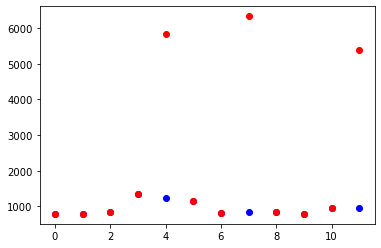

In [8]:
#compare old (red) and new (blue) pixels
x = np.arange(12)
plt.scatter(x, X[99,:,2,2,2], c='blue')
plt.scatter(x, B, c='red')

Comparing the blue and red dots above, we can see that the pixel values at month 4, 7 and 11 have been replaced with interpolated values.

In [9]:
#process_indices() from the Zindi custom module to calculate 4 indices NDVI, EVI2, MSI and NDWI.
#These four indices are assumed to be the most relevant. MOre experimentation is certainly required to see what valuable.
X_ind = process_indices(X)

Min =  -1.3498676081200351
Max =  4.278768233387358
Mean =  0.6596612801945116
Std =  0.4790663949492963
NDVI, EVI2, MSI & NDWI added to channels 0, 1, 2 & 3 respectively!
Processed input shape is:  (2552, 12, 40, 40, 4)


In [10]:
#std_scale_input() is from the Zindi custom module similar to sklearn standard scaler.
X_scaled, X_mean, X_std = std_scale_input(X)

Min =  -1.0646128501488141
Max =  10.992055702329584
Mean =  1.2458543899777187e-15
Std =  0.9999999999999997
Features of input array have been scaled!


In [11]:
#Once normalized, we need to confirmt eh distribution of the data hasn't been changes.
#We use Kendall Tau correlation coefficient to confirm.
#If the distribution of data before and after transformation is the same, 'stat' should be close to 1 and p < 0.05
from scipy.stats import kendalltau
stat, p = kendalltau(X[:7], X_scaled[:7])
print(stat, p)

0.9999999999974775 0.0


In [12]:
np.save('train_feat.npy', X)
np.save('train_ind.npy', X_ind)
#Load indices to bands 0, 1, 9 & 10
X_scaled[..., 0] = X_ind[..., 0]
X_scaled[..., 1] = X_ind[..., 1]
X_scaled[..., 9] = X_ind[..., 2]
X_scaled[..., 10] = X_ind[..., 3]
np.save('train_ind_scaled.npy', X_scaled)

In [13]:
#Only 6 months data kept (from Feb to July). All bands preserved.
X_6mos = np.delete(X_scaled, [0,7,8,9,10,11], 1)
np.save('train_ind_scaled_6m.npy', X_6mos)

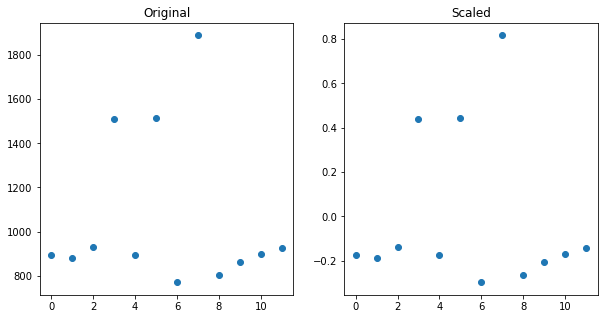

In [14]:
#Vizualize a sample pixel value across 12 months to see if the distribution has not changed.
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Original")
plt.scatter(x, X[199,:,10,10,2])

plt.subplot(122)
plt.title("Scaled")
plt.scatter(x, X_scaled[199,:,10,10,2])

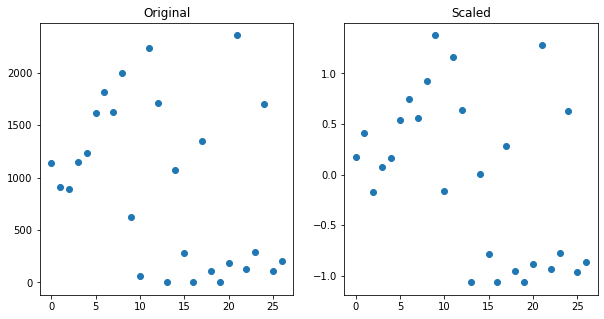

In [15]:
#Same check as above, except this time we're looking at a pixel at month 4 across all 27 channels.
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Original")
plt.scatter(np.arange(27), X[199,4,10,10,:])

plt.subplot(122)
plt.title("Scaled")
plt.scatter(np.arange(27), X_scaled[199,4,10,10,:])

## Test Data Preparation
Repeat the above steps for test data. This time, normalizing is done using the mean and std from train set.

In [16]:
X_test = read_test_img()

Adding satellite image data to Numpy array ----------
Shape of final train array: (1055, 12, 40, 40, 27)
Min =  0.0
Max =  13900.0
Mean =  1045.872578268533
Std =  1048.913988926129


In [17]:
np.save('test_raw.npy', X_test)

In [18]:
#Check if any values are nan
sumX_test = cp.sum(X_test)
print(cp.isnan(sumX_test))

False


In [19]:
X_test.shape

(1055, 12, 40, 40, 27)

In [20]:
#Cloud mask for test set
X_test[..., :12][X_test[..., 13]>0] = np.nan
for sample in range(1055):
    for w in range(40):
        for h in range(40):
            for ch in range(12):
                X_test[sample,: , w, h, ch] = fill_nan(X_test[sample,: , w, h, ch])

In [21]:
#Calculate indices
X_test_ind = process_indices(X_test)

Min =  -1.40069848661234
Max =  5.018656716417911
Mean =  0.6871267553064154
Std =  0.4852161167915641
NDVI, EVI2, MSI & NDWI added to channels 0, 1, 2 & 3 respectively!
Processed input shape is:  (1055, 12, 40, 40, 4)


In [22]:
#Scale inputs using mean and std from train set
X_test_scaled = (X_test - X_mean) / X_std

In [23]:
np.save('test_feat.npy', X_test)
np.save('test_ind.npy', X_test_ind)
#Load indices to bands 0, 1, 9 & 10
X_scaled[..., 0] = X_ind[..., 0]
X_scaled[..., 1] = X_ind[..., 1]
X_scaled[..., 9] = X_ind[..., 2]
X_scaled[..., 10] = X_ind[..., 3]
np.save('test_ind_scaled.npy', X_test_scaled)

In [24]:
#Only 6 months data kept (from Feb to July). All bands preserved.
X_test_6mos = np.delete(X_test_scaled, [0,7,8,9,10,11], 1)
np.save('test_ind_scaled_6m.npy', X_test_6mos)